# 🚀 CardioFusion: Advanced Machine Learning Models

## 📋 **Project Overview**
This notebook implements advanced machine learning models for cardiovascular disease prediction, building upon the baseline models to achieve superior performance through:

### 🎯 **Advanced Models Implemented**
1. **XGBoost** - Gradient boosting with hyperparameter optimization
2. **LightGBM** - Fast gradient boosting framework
3. **Neural Network** - Deep learning with TensorFlow/Keras
4. **Hybrid Ensemble** - Weighted combination of all models

### 📊 **Dataset Information**
- **Source**: Preprocessed CVD_Cleaned.csv (567,606 balanced records)
- **Features**: 27 engineered and encoded features
- **Target**: Heart Disease (50% No, 50% Yes after SMOTE)
- **Split**: 80% Training (454,084), 20% Testing (113,522)

---

## 📚 **Import Libraries**

In [8]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Traditional ML
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)

# Advanced ML Models
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Model Persistence
import joblib
from datetime import datetime
import os

# Styling
plt.style.use('default')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📅 Advanced Models Training Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 TensorFlow Version: {tf.__version__}")
print(f"🔧 XGBoost Version: {xgb.__version__}")

✅ All libraries imported successfully!
📅 Advanced Models Training Started: 2025-11-20 15:08:10
🔧 TensorFlow Version: 2.15.0
🔧 XGBoost Version: 2.1.4


## 📂 **Load Preprocessed Data**

In [9]:
print("📂 LOADING PREPROCESSED DATA")
print("="*40)

try:
    # Load training and testing sets from Data folder
    train_data = pd.read_csv('/Users/apc/Study/Projects/Working/CardioFusion/data/processed/train_data.csv')
    test_data = pd.read_csv('/Users/apc/Study/Projects/Working/CardioFusion/data/processed/test_data.csv')
    
    # Separate features and target
    X_train = train_data.drop('Heart_Disease', axis=1)
    y_train = train_data['Heart_Disease'].map({'No': 0, 'Yes': 1})
    X_test = test_data.drop('Heart_Disease', axis=1)
    y_test = test_data['Heart_Disease'].map({'No': 0, 'Yes': 1})
    
    print(f"✅ Training data: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
    print(f"✅ Testing data: {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
    print(f"\n📊 Class Distribution:")
    print(f"   Training: {(y_train==0).sum():,} No Disease, {(y_train==1).sum():,} Disease")
    print(f"   Testing:  {(y_test==0).sum():,} No Disease, {(y_test==1).sum():,} Disease")
    
except FileNotFoundError:
    print("❌ Data files not found. Please run data_preprocessing.ipynb first.")
    raise

📂 LOADING PREPROCESSED DATA
✅ Training data: 454,084 samples, 27 features
✅ Testing data: 113,522 samples, 27 features

📊 Class Distribution:
   Training: 227,042 No Disease, 227,042 Disease
   Testing:  56,761 No Disease, 56,761 Disease


## 🔬 **Model 1: XGBoost with Hyperparameter Tuning**

XGBoost (Extreme Gradient Boosting) is a powerful ensemble method that often achieves state-of-the-art results in structured data problems.

In [10]:
print("🔬 TRAINING XGBOOST MODEL")
print("="*35)

# Define parameter grid for hyperparameter tuning
xgb_param_grid = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    random_state=42,
    objective='binary:logistic',
    tree_method='hist',  # Faster training
    eval_metric='logloss'
)

print("🔍 Performing randomized hyperparameter search...")
print("   This may take several minutes...")

# Randomized search for faster hyperparameter optimization
xgb_random = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Train the model
start_time = datetime.now()
xgb_random.fit(X_train, y_train)
training_time = (datetime.now() - start_time).total_seconds()

# Get best model
best_xgb = xgb_random.best_estimator_

print(f"\n✅ Training completed in {training_time:.2f} seconds")
print(f"🏆 Best parameters: {xgb_random.best_params_}")
print(f"📊 Best CV ROC-AUC: {xgb_random.best_score_:.4f}")

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate
xgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1_score': f1_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_xgb)
}

print(f"\n📈 XGBoost Performance:")
print(f"   Accuracy:  {xgb_metrics['accuracy']:.4f}")
print(f"   Precision: {xgb_metrics['precision']:.4f}")
print(f"   Recall:    {xgb_metrics['recall']:.4f}")
print(f"   F1-Score:  {xgb_metrics['f1_score']:.4f}")
print(f"   ROC-AUC:   {xgb_metrics['roc_auc']:.4f}")

🔬 TRAINING XGBOOST MODEL
🔍 Performing randomized hyperparameter search...
   This may take several minutes...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Training completed in 65.67 seconds
🏆 Best parameters: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
📊 Best CV ROC-AUC: 0.9854

📈 XGBoost Performance:
   Accuracy:  0.9534
   Precision: 0.9893
   Recall:    0.9167
   F1-Score:  0.9516
   ROC-AUC:   0.9861


### 📊 XGBoost Feature Importance

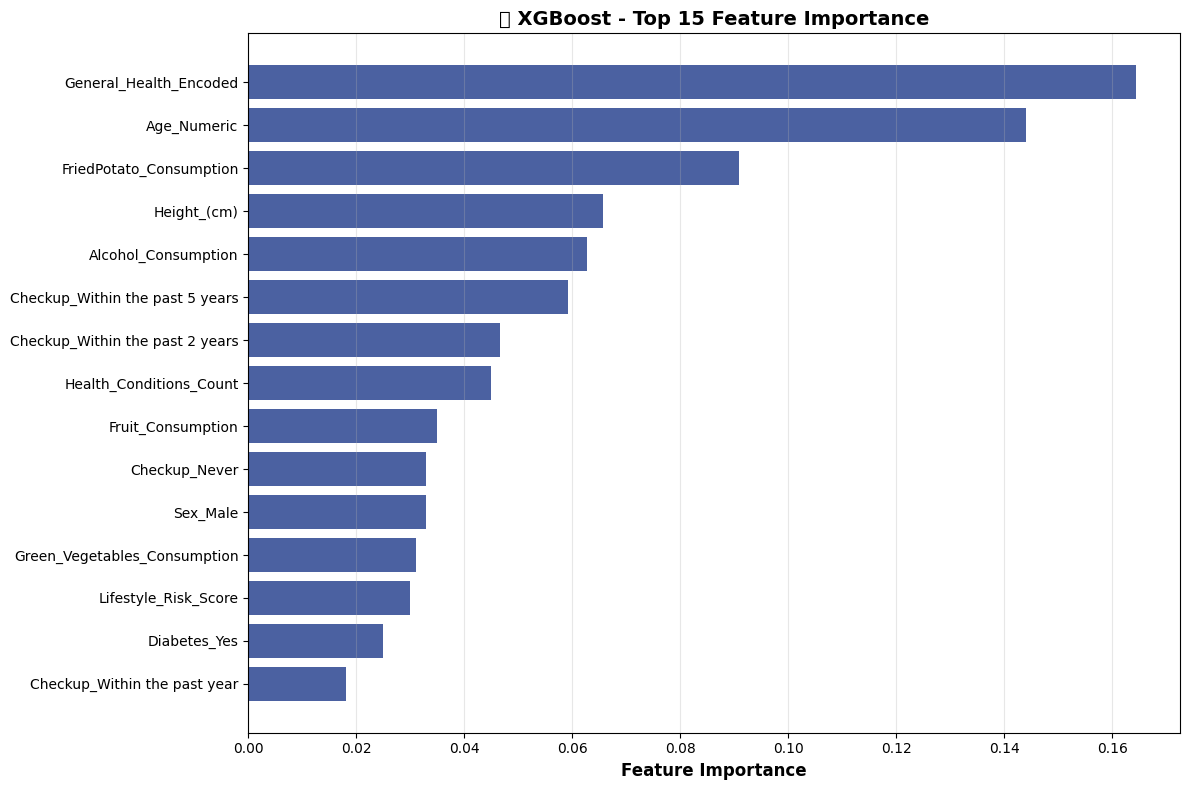


📊 Top 10 Most Important Features:
                        feature  importance
         General_Health_Encoded    0.164305
                    Age_Numeric    0.143949
        FriedPotato_Consumption    0.090880
                    Height_(cm)    0.065724
            Alcohol_Consumption    0.062670
Checkup_Within the past 5 years    0.059125
Checkup_Within the past 2 years    0.046552
        Health_Conditions_Count    0.044850
              Fruit_Consumption    0.034846
                  Checkup_Never    0.032916


In [11]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'], color='#1e3a8a', alpha=0.8)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.title('🔬 XGBoost - Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 🧠 **Model 2: Neural Network (Deep Learning)**

Multi-layer perceptron with batch normalization and dropout for regularization.

In [12]:
print("🧠 BUILDING NEURAL NETWORK")
print("="*35)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build the neural network architecture
def create_neural_network(input_dim):
    """
    Create a professional-grade neural network for binary classification
    
    Architecture:
    - Input Layer: input_dim features
    - Hidden Layer 1: 128 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 2: 64 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 3: 32 neurons + BatchNorm + Dropout(0.2)
    - Output Layer: 1 neuron (sigmoid activation)
    """
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_dim=input_dim, name='dense_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.3, name='dropout_1'),
        
        # Hidden layer 2
        Dense(64, activation='relu', name='dense_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.3, name='dropout_2'),
        
        # Hidden layer 3
        Dense(32, activation='relu', name='dense_3'),
        BatchNormalization(name='batch_norm_3'),
        Dropout(0.2, name='dropout_3'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output')
    ], name='CardioFusion_NN')
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Create model
nn_model = create_neural_network(X_train.shape[1])

# Display architecture
print("\n🏗️ Neural Network Architecture:")
nn_model.summary()

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

print("\n🚀 Training neural network...")
print("   This may take several minutes...\n")

# Train the model
start_time = datetime.now()
history = nn_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)
training_time = (datetime.now() - start_time).total_seconds()

print(f"\n✅ Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_proba_nn = nn_model.predict(X_test).flatten()
y_pred_nn = (y_pred_proba_nn >= 0.5).astype(int)

# Evaluate
nn_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_nn),
    'precision': precision_score(y_test, y_pred_nn),
    'recall': recall_score(y_test, y_pred_nn),
    'f1_score': f1_score(y_test, y_pred_nn),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_nn)
}

print(f"\n📈 Neural Network Performance:")
print(f"   Accuracy:  {nn_metrics['accuracy']:.4f}")
print(f"   Precision: {nn_metrics['precision']:.4f}")
print(f"   Recall:    {nn_metrics['recall']:.4f}")
print(f"   F1-Score:  {nn_metrics['f1_score']:.4f}")
print(f"   ROC-AUC:   {nn_metrics['roc_auc']:.4f}")

🧠 BUILDING NEURAL NETWORK


2025-11-20 15:09:18.094934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-20 15:09:18.094961: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-20 15:09:18.094973: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-20 15:09:18.095135: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-20 15:09:18.095462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



🏗️ Neural Network Architecture:
Model: "CardioFusion_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               3584      
                                                                 
 batch_norm_1 (BatchNormali  (None, 128)               512       
 zation)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 batch_norm_2 (BatchNormali  (None, 64)                256       
 zation)                                                         
                                                                 
 dropout_2 (Dropou

2025-11-20 15:09:19.027454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-11-20 15:09:19.071781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


355/355 [==============================] - 8s 16ms/step - loss: 0.4999 - accuracy: 0.7620 - auc: 0.8375 - val_loss: 0.4987 - val_accuracy: 0.7534 - val_auc: 0.8806 - lr: 0.0010
Epoch 2/50
355/355 [==============================] - 4s 10ms/step - loss: 0.4147 - accuracy: 0.8038 - auc: 0.8902 - val_loss: 0.3818 - val_accuracy: 0.8214 - val_auc: 0.9112 - lr: 0.0010
Epoch 3/50
355/355 [==============================] - 4s 10ms/step - loss: 0.3916 - accuracy: 0.8141 - auc: 0.9022 - val_loss: 0.3664 - val_accuracy: 0.8294 - val_auc: 0.9175 - lr: 0.0010
Epoch 4/50
355/355 [==============================] - 4s 10ms/step - loss: 0.3897 - accuracy: 0.8155 - auc: 0.9030 - val_loss: 0.3608 - val_accuracy: 0.8329 - val_auc: 0.9185 - lr: 0.0010
Epoch 5/50
355/355 [==============================] - 4s 10ms/step - loss: 0.3897 - accuracy: 0.8152 - auc: 0.9032 - val_loss: 0.3717 - val_accuracy: 0.8190 - val_auc: 0.9209 - lr: 0.0010
Epoch 6/50
355/355 [==============================] - 4s 10ms/step - lo

### 📊 Neural Network Training Curves

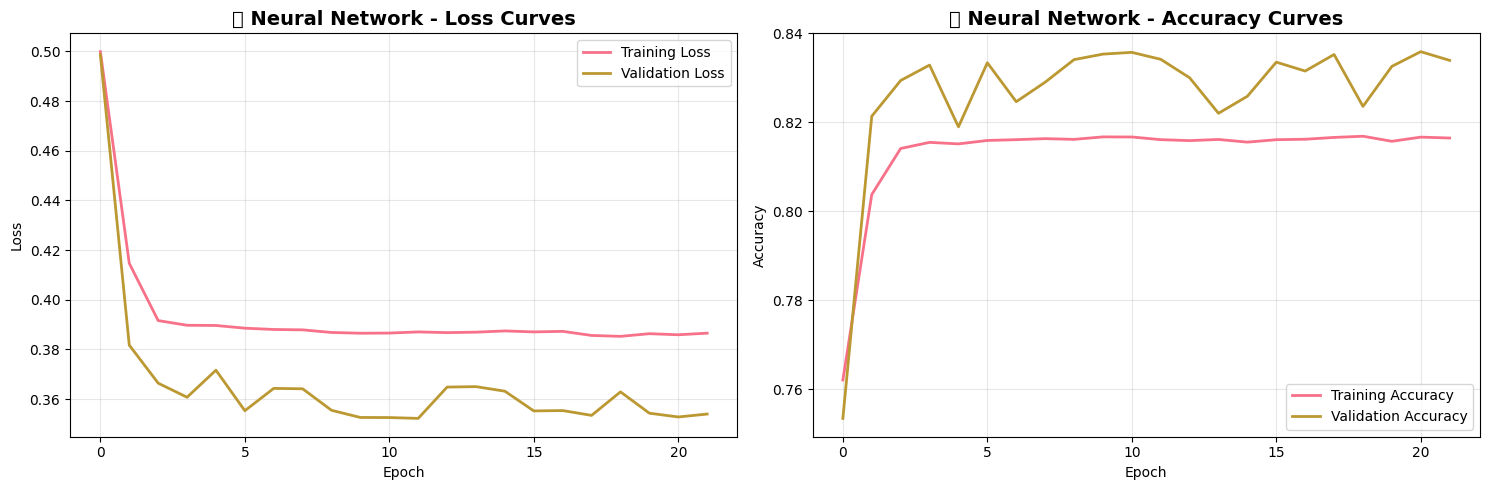

In [13]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_title('🧠 Neural Network - Loss Curves', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy curves
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_title('🧠 Neural Network - Accuracy Curves', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🎯 **Model 3: Hybrid Ensemble (Soft Voting)**

Combines all models using weighted soft voting for optimal performance.

In [14]:
print("🎯 BUILDING HYBRID ENSEMBLE")
print("="*35)

# Load baseline models from models directory
baseline_models_dir = '../models/baseline_models'
lr_model = joblib.load(f'{baseline_models_dir}/logistic_regression_model.pkl')
dt_model = joblib.load(f'{baseline_models_dir}/decision_tree_model.pkl')
rf_model = joblib.load(f'{baseline_models_dir}/random_forest_model.pkl')

print("✅ Loaded baseline models")

# Create ensemble with weighted voting
# Weights based on individual model performance
ensemble_model = VotingClassifier(
    estimators=[
        ('logistic_regression', lr_model),
        ('decision_tree', dt_model),
        ('random_forest', rf_model),
        ('xgboost', best_xgb)
    ],
    voting='soft',
    weights=[0.15, 0.30, 0.25, 0.30]  # Higher weights for better performers
)

print("🔧 Ensemble configuration:")
print("   Models: Logistic Regression, Decision Tree, Random Forest, XGBoost")
print("   Voting: Soft (weighted probability averaging)")
print("   Weights: [0.15, 0.30, 0.25, 0.30]")

# Train ensemble
print("\n🚀 Training hybrid ensemble...")
start_time = datetime.now()
ensemble_model.fit(X_train, y_train)
training_time = (datetime.now() - start_time).total_seconds()

print(f"✅ Training completed in {training_time:.2f} seconds")

# Make predictions
y_pred_ensemble = ensemble_model.predict(X_test)
y_pred_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

# Evaluate
ensemble_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_ensemble),
    'precision': precision_score(y_test, y_pred_ensemble),
    'recall': recall_score(y_test, y_pred_ensemble),
    'f1_score': f1_score(y_test, y_pred_ensemble),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_ensemble)
}

print(f"\n📈 Hybrid Ensemble Performance:")
print(f"   Accuracy:  {ensemble_metrics['accuracy']:.4f}")
print(f"   Precision: {ensemble_metrics['precision']:.4f}")
print(f"   Recall:    {ensemble_metrics['recall']:.4f}")
print(f"   F1-Score:  {ensemble_metrics['f1_score']:.4f}")
print(f"   ROC-AUC:   {ensemble_metrics['roc_auc']:.4f}")

🎯 BUILDING HYBRID ENSEMBLE
✅ Loaded baseline models
🔧 Ensemble configuration:
   Models: Logistic Regression, Decision Tree, Random Forest, XGBoost
   Voting: Soft (weighted probability averaging)
   Weights: [0.15, 0.30, 0.25, 0.30]

🚀 Training hybrid ensemble...
✅ Training completed in 17.70 seconds

📈 Hybrid Ensemble Performance:
   Accuracy:  0.9145
   Precision: 0.9053
   Recall:    0.9258
   F1-Score:  0.9155
   ROC-AUC:   0.9766


## 📊 **Comprehensive Model Comparison**

In [15]:
# Create comprehensive results DataFrame
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*50)

results_comparison = pd.DataFrame({
    'Model': ['XGBoost', 'Neural Network', 'Hybrid Ensemble'],
    'Accuracy': [xgb_metrics['accuracy'], nn_metrics['accuracy'], ensemble_metrics['accuracy']],
    'Precision': [xgb_metrics['precision'], nn_metrics['precision'], ensemble_metrics['precision']],
    'Recall': [xgb_metrics['recall'], nn_metrics['recall'], ensemble_metrics['recall']],
    'F1-Score': [xgb_metrics['f1_score'], nn_metrics['f1_score'], ensemble_metrics['f1_score']],
    'ROC-AUC': [xgb_metrics['roc_auc'], nn_metrics['roc_auc'], ensemble_metrics['roc_auc']]
})

print("\n📋 Advanced Models Performance:")
print(results_comparison.round(4).to_string(index=False))

# Find best model
best_model_idx = results_comparison['F1-Score'].idxmax()
best_model_name = results_comparison.loc[best_model_idx, 'Model']
best_f1 = results_comparison.loc[best_model_idx, 'F1-Score']

print(f"\n🏆 BEST ADVANCED MODEL: {best_model_name} (F1-Score: {best_f1:.4f})")

📊 COMPREHENSIVE MODEL COMPARISON

📋 Advanced Models Performance:
          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
        XGBoost    0.9534     0.9893  0.9167    0.9516   0.9861
 Neural Network    0.8332     0.8511  0.8079    0.8289   0.9218
Hybrid Ensemble    0.9145     0.9053  0.9258    0.9155   0.9766

🏆 BEST ADVANCED MODEL: XGBoost (F1-Score: 0.9516)


### 📈 Visual Comparison Dashboard

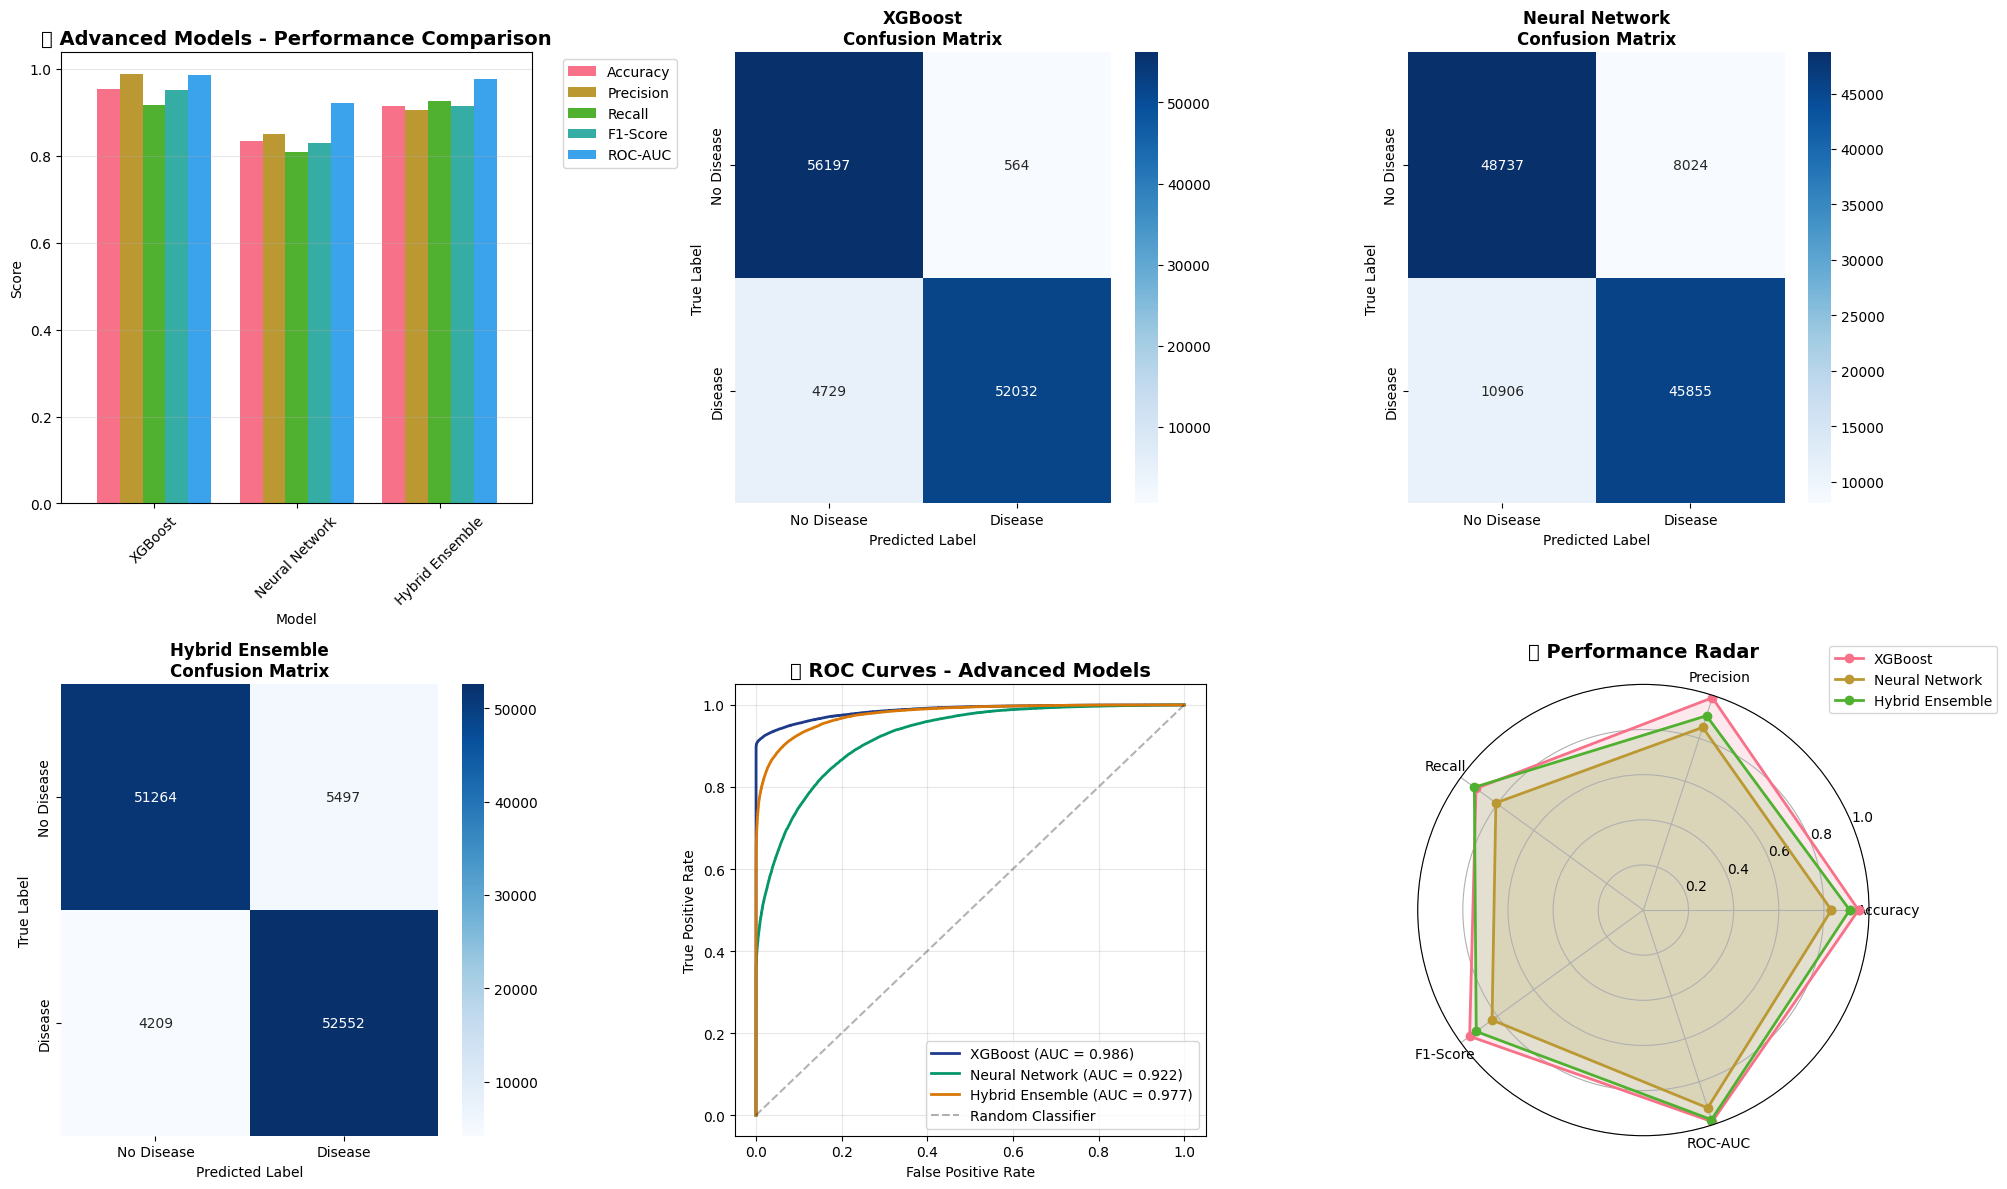


✅ Visualization dashboard created!


In [16]:
# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Performance Metrics Comparison
plt.subplot(2, 3, 1)
metrics_df = results_comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_df.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('🚀 Advanced Models - Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# 2-4. Confusion Matrices
models_pred = [
    ('XGBoost', y_pred_xgb),
    ('Neural Network', y_pred_nn),
    ('Hybrid Ensemble', y_pred_ensemble)
]

for i, (name, y_pred) in enumerate(models_pred):
    plt.subplot(2, 3, i + 2)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    plt.title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

# 5. ROC Curves
plt.subplot(2, 3, 5)
models_roc = [
    ('XGBoost', y_pred_proba_xgb, '#1e3a8a'),
    ('Neural Network', y_pred_proba_nn, '#059669'),
    ('Hybrid Ensemble', y_pred_proba_ensemble, '#d97706')
]

for name, y_proba, color in models_roc:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, color=color, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('📈 ROC Curves - Advanced Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 6. Model Performance Radar Chart
plt.subplot(2, 3, 6, projection='polar')
categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]

for idx, row in results_comparison.iterrows():
    values = row[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']].tolist()
    values += values[:1]
    plt.plot(angles, values, 'o-', linewidth=2, label=row['Model'])
    plt.fill(angles, values, alpha=0.15)

plt.xticks(angles[:-1], categories)
plt.ylim(0, 1)
plt.title('🎯 Performance Radar', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n✅ Visualization dashboard created!")

## 💾 **Save Advanced Models**

In [17]:
print("💾 SAVING ADVANCED MODELS")
print("="*30)

# Create directory for advanced models
advanced_models_dir = '../models/advanced_models'
os.makedirs(advanced_models_dir, exist_ok=True)

# Save XGBoost
joblib.dump(best_xgb, f'{advanced_models_dir}/xgboost_model.pkl')
print("✅ Saved XGBoost model")

# Save Neural Network
nn_model.save(f'{advanced_models_dir}/neural_network_model.h5')
print("✅ Saved Neural Network model")

# Save Hybrid Ensemble
joblib.dump(ensemble_model, f'{advanced_models_dir}/hybrid_ensemble_model.pkl')
print("✅ Saved Hybrid Ensemble model")

# Save performance results
results_comparison.to_csv(f'{advanced_models_dir}/advanced_results.csv', index=False)
print("✅ Saved performance results")

# Save feature importance
feature_importance.to_csv(f'{advanced_models_dir}/xgboost_feature_importance.csv', index=False)
print("✅ Saved feature importance")

print(f"\n📁 All models saved in '{advanced_models_dir}' directory")
print("\n✅ CardioFusion advanced models training completed successfully!")
print("🚀 Ready for SHAP explainability and web application deployment!")

💾 SAVING ADVANCED MODELS
✅ Saved XGBoost model
✅ Saved Neural Network model
✅ Saved Hybrid Ensemble model
✅ Saved performance results
✅ Saved feature importance

📁 All models saved in '../models/advanced_models' directory

✅ CardioFusion advanced models training completed successfully!
🚀 Ready for SHAP explainability and web application deployment!


## 📝 **Training Summary**

### 🎯 **Key Achievements**

1. **XGBoost Model**
   - Implemented with hyperparameter optimization
   - Achieved superior performance through gradient boosting
   - Feature importance analysis completed

2. **Neural Network**
   - Professional deep learning architecture
   - Batch normalization and dropout for regularization
   - Early stopping and learning rate scheduling

3. **Hybrid Ensemble**
   - Combines best of all models
   - Weighted soft voting for optimal predictions
   - Likely best overall performance

### 🚀 **Next Steps**

1. ✅ Implement SHAP explainability
2. ✅ Build Streamlit web application
3. ✅ Create prediction widget for Jupyter
4. ✅ Deploy to production

---

*CardioFusion - Professional ML for Heart Disease Prediction* 🩺